In [5]:
import numpy as np
import pandas as pd
import plotly.express as px

import cv2
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report, confusion_matrix

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.utils import to_categorical

import os
import random
import warnings

In [8]:
train_dir = "C:/Users/iisha_ol6x3qs/Documents/miniProject/backEnd/train"
test_dir = "C:/Users/iisha_ol6x3qs/Documents/miniProject/backEnd/test"
validation_dir = "C:/Users/iisha_ol6x3qs/Documents/miniProject/backEnd/validation"

# Count images in each category
def count_images(directory):
    categories = os.listdir(directory)
    category_count = {category: len(os.listdir(os.path.join(directory, category))) for category in categories}
    return category_count

train_count = count_images(train_dir)
test_count = count_images(test_dir)
validation_count = count_images(validation_dir)

df_train = pd.DataFrame(list(train_count.items()), columns=["vegetable", "train_count"])
df_test = pd.DataFrame(list(test_count.items()), columns=["vegetable", "test_count"])
df_validation = pd.DataFrame(list(validation_count.items()), columns=["vegetable", "validation_count"])

df = pd.merge(df_train, df_test, on="vegetable")
df = pd.merge(df, df_validation, on="vegetable")

# Plot the counts
fig = px.bar(df, x="vegetable", y=["train_count", "test_count", "validation_count"], 
             title='Image Count per Vegetable Category', 
             labels={'value':'Image Count', 'variable':'Dataset Split'})
fig.show()

In [9]:
os.listdir(train_dir)

['Bean',
 'Bitter_Gourd',
 'Bottle_Gourd',
 'Brinjal',
 'Broccoli',
 'Cabbage',
 'Capsicum',
 'Carrot',
 'Cauliflower',
 'Cucumber',
 'Papaya',
 'Potato',
 'Pumpkin',
 'Radish',
 'Tomato']

In [10]:
categories = os.listdir(train_dir)
category_count = {category: len(os.listdir(os.path.join(train_dir, category))) for category in categories}

In [11]:
category_count

{'Bean': 1000,
 'Bitter_Gourd': 1000,
 'Bottle_Gourd': 1000,
 'Brinjal': 1000,
 'Broccoli': 1000,
 'Cabbage': 1000,
 'Capsicum': 1000,
 'Carrot': 1000,
 'Cauliflower': 1000,
 'Cucumber': 1000,
 'Papaya': 1000,
 'Potato': 1000,
 'Pumpkin': 1000,
 'Radish': 1000,
 'Tomato': 1000}

In [12]:
# Function to load a sample of images and labels
def load_sample_images_from_folder(folder, sample_fraction=0.5):
    images = []
    labels = []
    for category in os.listdir(folder):
        label = category
        category_path = os.path.join(folder, category)
        all_files = os.listdir(category_path)
        sample_files = random.sample(all_files, int(len(all_files) * sample_fraction))
        for filename in sample_files:
            img_path = os.path.join(category_path, filename)
            img = cv2.imread(img_path)
            if img is not None:
                img = cv2.resize(img, (224, 224))
                images.append(img)
                labels.append(label)
    return np.array(images), np.array(labels)

# Load sample datasets
X_train, y_train = load_sample_images_from_folder(train_dir)
X_test, y_test = load_sample_images_from_folder(test_dir)
X_val, y_val = load_sample_images_from_folder(validation_dir)

In [13]:
# Normalize images
X_train = X_train / 255.0
X_test = X_test / 255.0
X_val = X_val / 255.0

In [14]:
# Convert labels to one-hot encoding
lb = LabelBinarizer()
y_train = lb.fit_transform(y_train)
y_test = lb.transform(y_test)
y_val = lb.transform(y_val)

In [15]:

# Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

datagen.fit(X_train)

In [16]:
# Building the model
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(224, 224, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dropout(0.5),
    Dense(len(lb.classes_), activation='softmax')
])

model.compile(optimizer="adam", 
              loss = "categorical_crossentropy",
              metrics=["accuracy"])

c:\Users\iisha_ol6x3qs\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:107: UserWarning:

Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.



In [17]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 222, 222, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 109, 109, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 54, 54, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 52, 52, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 26, 26, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 86528)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │    44,302,848 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 15)             │         7,695 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 44,403,791 (169.39 MB)

 Trainable params: 44,403,791 (169.39 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Callback
early_stopping = EarlyStopping(monitor="val_loss", patience=10)
model_checkpoint = ModelCheckpoint("kaggle/working/best_model.keras", monitor="val_loss", save_best_only=True)

# Training the model
history = model.fit(datagen.flow(X_train, y_train, batch_size=32),
                   epochs=50,
                   validation_data=(X_val, y_val),
                   callbacks=[early_stopping, model_checkpoint])

Epoch 1/50


c:\Users\iisha_ol6x3qs\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:120: UserWarning:

Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.



235/235 ━━━━━━━━━━━━━━━━━━━━ 298s 1s/step - accuracy: 0.2693 - loss: 2.2348 - val_accuracy: 0.5773 - val_loss: 1.1920
Epoch 2/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 299s 1s/step - accuracy: 0.6018 - loss: 1.1927 - val_accuracy: 0.7527 - val_loss: 0.7217
Epoch 3/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 268s 1s/step - accuracy: 0.6945 - loss: 0.9257 - val_accuracy: 0.8313 - val_loss: 0.5244
Epoch 4/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 247s 1s/step - accuracy: 0.7404 - loss: 0.7809 - val_accuracy: 0.7960 - val_loss: 0.6859
Epoch 5/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 227s 955ms/step - accuracy: 0.7817 - loss: 0.6494 - val_accuracy: 0.8867 - val_loss: 0.3569
Epoch 6/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 245s 1s/step - accuracy: 0.8084 - loss: 0.5883 - val_accuracy: 0.8960 - val_loss: 0.3091
Epoch 7/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 233s 984ms/step - accuracy: 0.8243 - loss: 0.5419 - val_accuracy: 0.8913 - val_loss: 0.3687
Epoch 8/50
235/235 ━━━━━━━━━━━━━━━━━━━━ 231s 972ms/step - accuracy: 0.8563 - loss: 0.4328 - val_accura

In [22]:
from tensorflow.keras.models import load_model

# Load the best model (adjust the path as needed)
best_model = load_model("C:/Users/iisha_ol6x3qs/Documents/miniProject/backEnd/ingredient_model.keras")

# Evaluate on test data
test_loss, test_accuracy = best_model.evaluate(X_test, y_test)
print(f"Test Loss: {test_loss}, Test Accuracy: {test_accuracy}")


47/47 ━━━━━━━━━━━━━━━━━━━━ 101s 2s/step - accuracy: 0.9592 - loss: 0.1067
Test Loss: 0.19874969124794006, Test Accuracy: 0.9246666431427002


In [23]:
# Plot training history
fig = px.line(pd.DataFrame(history.history), 
              y=['accuracy', 'val_accuracy'], 
              title='Model Accuracy',
              labels={'index': 'Epoch', 'value': 'Accuracy'})
fig.show()

fig = px.line(pd.DataFrame(history.history), 
              y=['loss', 'val_loss'], 
              title='Model Loss',
              labels={'index': 'Epoch', 'value': 'Loss'})
fig.show()


In [24]:
# Confusion Matrix and Classification Report
y_pred = best_model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true_classes = np.argmax(y_test, axis=1)

47/47 ━━━━━━━━━━━━━━━━━━━━ 99s 2s/step


In [26]:
import matplotlib.pyplot as plt
import seaborn as sns

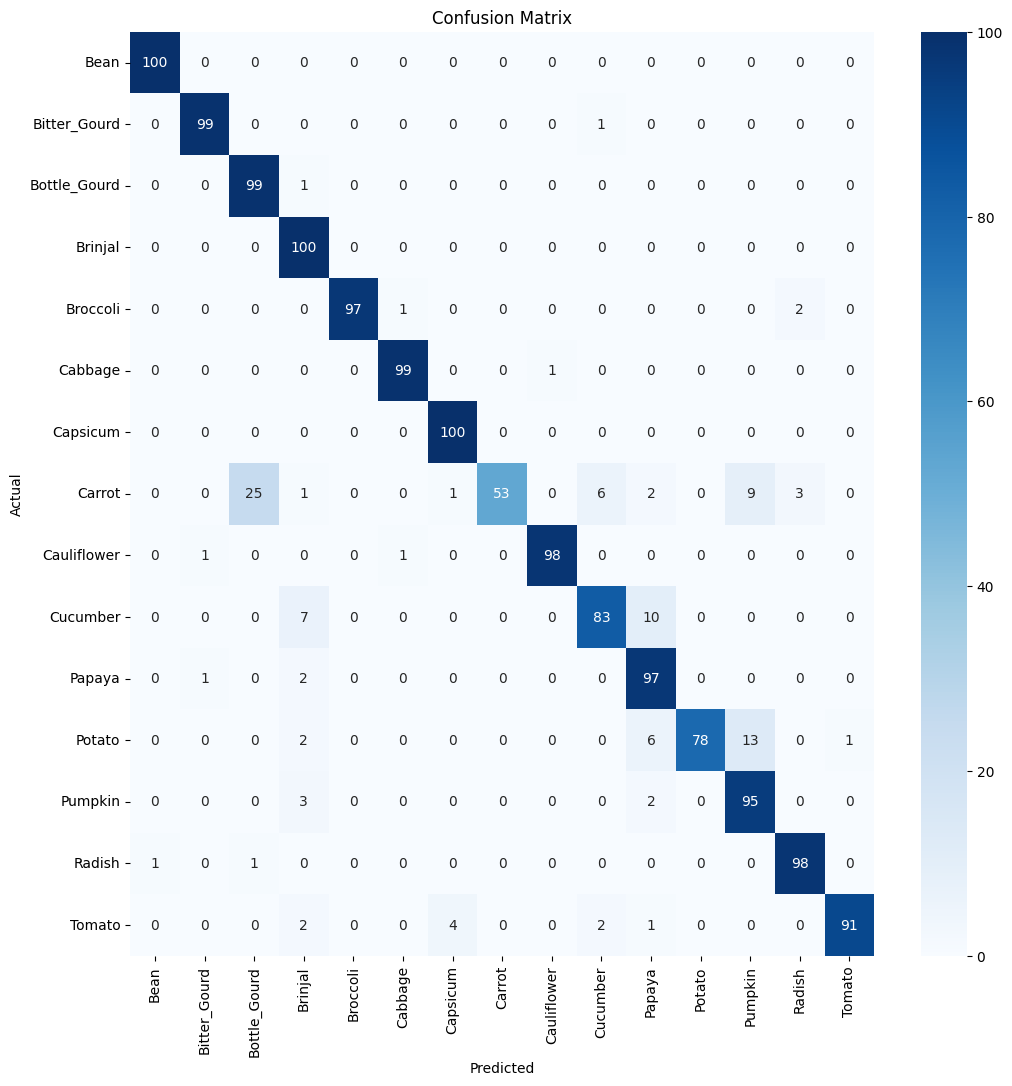

In [27]:
# Confusion Matrix
cm = confusion_matrix(y_true_classes, y_pred_classes)
plt.figure(figsize=(12, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=lb.classes_, yticklabels=lb.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [28]:
# Classification Report
cr = classification_report(y_true_classes, y_pred_classes, target_names=lb.classes_)
print('Classification Report:')
print(cr)

Classification Report:
              precision    recall  f1-score   support

        Bean       0.99      1.00      1.00       100
Bitter_Gourd       0.98      0.99      0.99       100
Bottle_Gourd       0.79      0.99      0.88       100
     Brinjal       0.85      1.00      0.92       100
    Broccoli       1.00      0.97      0.98       100
     Cabbage       0.98      0.99      0.99       100
    Capsicum       0.95      1.00      0.98       100
      Carrot       1.00      0.53      0.69       100
 Cauliflower       0.99      0.98      0.98       100
    Cucumber       0.90      0.83      0.86       100
      Papaya       0.82      0.97      0.89       100
      Potato       1.00      0.78      0.88       100
     Pumpkin       0.81      0.95      0.88       100
      Radish       0.95      0.98      0.97       100
      Tomato       0.99      0.91      0.95       100

    accuracy                           0.92      1500
   macro avg       0.93      0.92      0.92      1500
wei

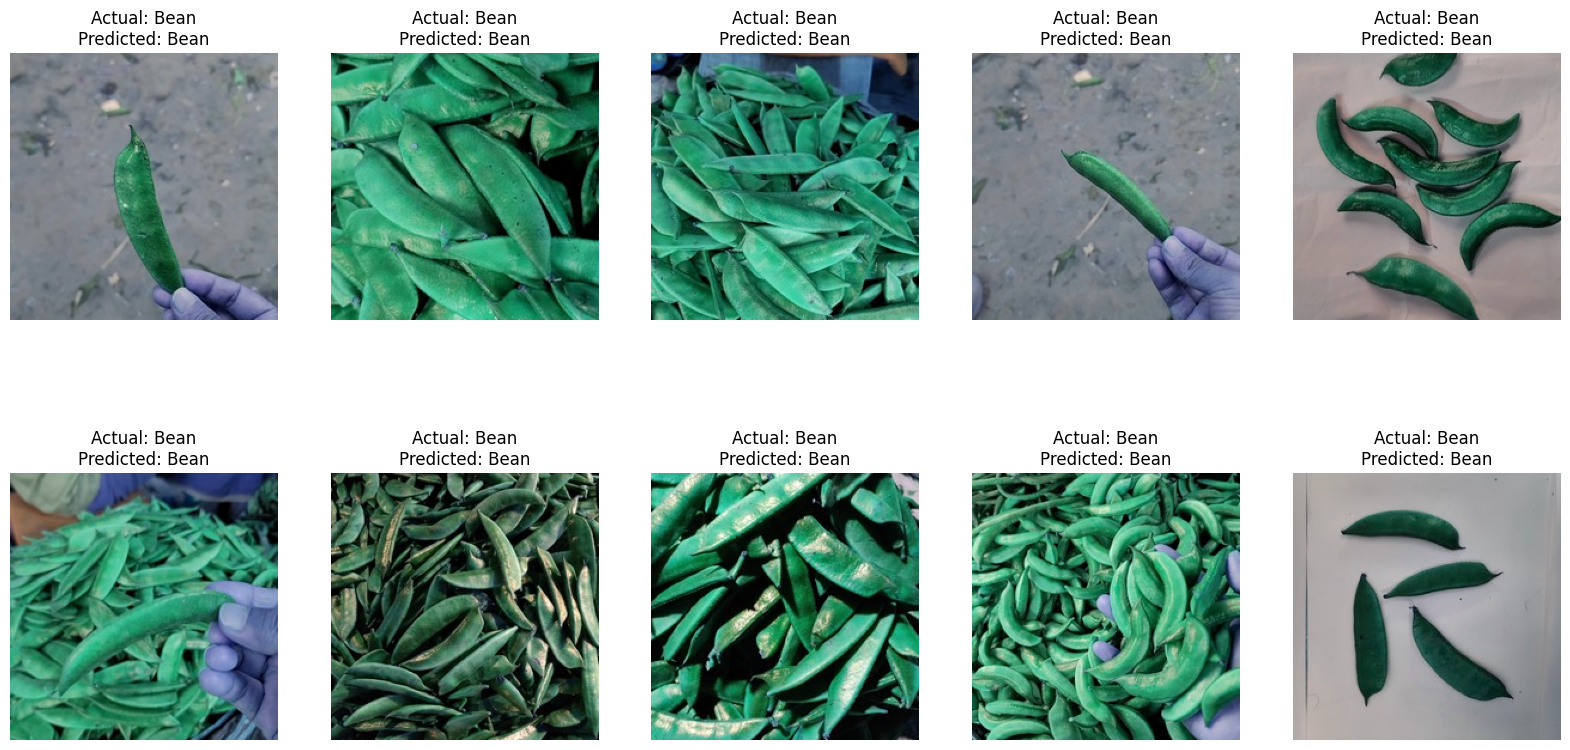

In [29]:
# Display 10 sample predictions
plt.figure(figsize=(20, 10))
for i in range(10):
    plt.subplot(2, 5, i+1)
    plt.imshow(X_test[i])
    plt.title(f"Actual: {lb.classes_[y_true_classes[i]]}\nPredicted: {lb.classes_[y_pred_classes[i]]}")
    plt.axis('off')
plt.show()